<a href="https://colab.research.google.com/github/garrett-davidson-16/bioinformatics-final/blob/main/Final_Davidson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Data**

In [23]:
import re
import pandas as pd
import gzip # Import the gzip module

# -------------------------------------
# Path to the GSE81538 series matrix file
# -------------------------------------
matrix_file = "GSE81538_series_matrix.txt.gz" # Changed to .gz

# -------------------------------------
# Variables
# -------------------------------------
sample_ids = []
pam50_values = []
pam50_line_processed = False # Flag to ensure PAM50 values are extracted only once

# -------------------------------------
# Read file
# -------------------------------------
with gzip.open(matrix_file, "rt") as f: # Use gzip.open and 'rt' for reading text
    for line in f:
        # Extract GSM IDs once
        if line.startswith("!Sample_geo_accession"):
            parts = line.strip().split("\t")
            sample_ids = parts[1:]    # remove the prefix column
            sample_ids = [s.replace('"', '') for s in sample_ids]

        # Extract PAM50 subtypes only once from the first !Sample_characteristics_ch1 line containing it
        if not pam50_line_processed and line.startswith("!Sample_characteristics_ch1"):
            # Check if this line contains "pam50 subtype" to ensure it's the relevant one
            if "pam50 subtype:" in line.lower():
                # Remove line prefix
                line = line.strip()
                parts = line.split("\t")

                # parts[0] = '!Sample_characteristics_ch1'
                sample_fields = parts[1:]   # one entry per sample

                temp_pam50_values = [] # Collect values into a temporary list
                # Extract PAM50 subtype for each sample
                for field in sample_fields:
                    # remove quotes
                    clean = field.replace('"', '').strip()

                    # look for "pam50 subtype: something"
                    match = re.search(r'pam50 subtype:\s*(.*)', clean, re.IGNORECASE)
                    if match:
                        temp_pam50_values.append(match.group(1).strip())
                    else:
                        temp_pam50_values.append(None)

                # Assign to main list after processing the relevant line
                pam50_values = temp_pam50_values
                pam50_line_processed = True # Mark as processed

# -------------------------------------
# Build table
# -------------------------------------
df = pd.DataFrame({
    "Sample": sample_ids,
    "PAM50_subtype": pam50_values
})

print(df.head())
print(df.shape)

# Save to CSV
df.to_csv("GSE81538_PAM50_subtypes.csv", index=False)

       Sample PAM50_subtype
0  GSM2155558         Basal
1  GSM2155559          Her2
2  GSM2155560          LumB
3  GSM2155561          Her2
4  GSM2155562          LumB
(405, 2)


**Build Labels**

In [24]:
import gzip
import re
import pandas as pd

# ----------------------------------------------------
# 1. Extract PAM50 subtype annotations from Series Matrix
# ----------------------------------------------------
matrix_file = "GSE81538_series_matrix.txt.gz"
subtypes = []
pam50_line_processed = False # Flag to ensure PAM50 values are extracted only once

with gzip.open(matrix_file, "rt", encoding="utf-8") as f:
    for line in f:
        if not pam50_line_processed and line.startswith("!Sample_characteristics_ch1"):
            # Check if this line contains "pam50 subtype" to ensure it's the relevant one
            if "pam50 subtype:" in line.lower():
                # Split at tabs, skip first column
                fields = line.strip().split("\t")[1:]
                temp_subtypes = [] # Collect values into a temporary list
                for field in fields:
                    clean = field.replace('"', '').strip()
                    match = re.search(r"pam50 subtype:\s*([A-Za-z0-9_+-]+)", clean, re.IGNORECASE)
                    if match:
                        temp_subtypes.append(match.group(1))
                    else:
                        temp_subtypes.append(None)

                subtypes = temp_subtypes # Assign to main list after processing the relevant line
                pam50_line_processed = True # Mark as processed

# ----------------------------------------------------
# 2. Load first 5 rows of expression file to get sample order
# ----------------------------------------------------
expr_file = "GSE81538_gene_expression_405_transformed.csv.gz"
expr_head = pd.read_csv(expr_file, compression='gzip', nrows=5)
sample_ids = list(expr_head.columns[1:])  # Exclude gene column

# ----------------------------------------------------
# 3. Create DataFrame mapping sample → subtype
# ----------------------------------------------------
df = pd.DataFrame({
    "Sample": sample_ids,
    "Subtype": subtypes
})

# ----------------------------------------------------
# 4. Normalize subtype names
# ----------------------------------------------------
mapping = {
    "Basal": "Basal",
    "LumA": "Luminal_A",
    "LumB": "Luminal_B",
    "Her2": "Her2",
    "Normal": "Normal"
}
df["Subtype"] = df["Subtype"].map(mapping)

# ----------------------------------------------------
# 5. Remove samples labeled "Normal"
# ----------------------------------------------------
df = df[df["Subtype"] != "Normal"]

# ----------------------------------------------------
# 6. Save final labels file
# ----------------------------------------------------
df.to_csv("labels_4.csv", index=False)

**Load Expression matrix (x) and labels (y)**

In [25]:
import pandas as pd

# ------------------------------------------------------------
# Function to load and align gene expression data with labels
# ------------------------------------------------------------
def load_expression_and_labels(expr_file, label_file):
    # ---- Load expression matrix ----
    # First column = gene names → index
    expr = pd.read_csv(expr_file, compression='gzip')
    expr = expr.rename(columns={expr.columns[0]: "Gene"})
    expr = expr.set_index("Gene")

    # Transpose → samples × genes
    expr = expr.T

    # ---- Load labels ----
    labels = pd.read_csv(label_file)

    # Ensure column names
    assert "Sample" in labels.columns and "Subtype" in labels.columns, \
        "Label file must contain 'Sample' and 'Subtype' columns."

    # ---- Align samples between datasets ----
    common_samples = expr.index.intersection(labels["Sample"])

    # Filter expression and labels
    X = expr.loc[common_samples].copy()
    y = labels.set_index("Sample").loc[common_samples]["Subtype"].copy()

    return X, y


# ------------------------------------------------------------
# Call the function and inspect result
# ------------------------------------------------------------
expr_file = "GSE81538_gene_expression_405_transformed.csv.gz"
label_file = "labels_4.csv"

X, y = load_expression_and_labels(expr_file, label_file)

# Print summary
print("Expression matrix shape (samples × genes):", X.shape)
print("\nSubtype counts:")
print(y.value_counts())


Expression matrix shape (samples × genes): (383, 18802)

Subtype counts:
Subtype
Luminal_A    156
Luminal_B    105
Her2          65
Basal         57
Name: count, dtype: int64


**Differential Expression (One vs. All)**

In [26]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Dictionary to hold DE results per subtype
de_results = {}

subtypes = y.unique()

for subtype in subtypes:
    print(f"Running DE for {subtype} vs all")

    # Define groups
    mask_subtype = (y == subtype)
    mask_other = ~mask_subtype

    X_subtype = X.loc[mask_subtype]
    X_other = X.loc[mask_other]

    # Mean expression per gene in each group
    mean_subtype = X_subtype.mean(axis=0)
    mean_other = X_other.mean(axis=0)

    # Log2 fold change (data already logged)
    log2fc = mean_subtype - mean_other

    # Welch's t-test (unpaired, unequal variance) gene-by-gene
    t_stat, pvals = stats.ttest_ind(
        X_subtype.values,
        X_other.values,
        axis=0,
        equal_var=False,
        nan_policy='omit'
    )

    # Convert p-values to a Series aligned with gene names
    pvals = pd.Series(pvals, index=X.columns)

    # Replace NaNs (e.g., degenerate cases) with 1.0
    pvals = pvals.fillna(1.0)

    # Benjamini–Hochberg FDR correction
    reject, padj, _, _ = multipletests(pvals.values, alpha=0.05, method='fdr_bh')

    # Build results DataFrame
    res_df = pd.DataFrame({
        "gene": X.columns,
        "log2FC": log2fc.values,
        "pval": pvals.values,
        "padj": padj
    })

    # Sort by adjusted p-value
    res_df = res_df.sort_values("padj").reset_index(drop=True)

    # Store in dictionary
    de_results[subtype] = res_df

    # Print number of FDR-significant genes
    n_sig = (res_df["padj"] < 0.05).sum()
    print(f"{subtype}: {n_sig} significant genes")

Running DE for Basal vs all


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


Basal: 11707 significant genes
Running DE for Her2 vs all
Her2: 7146 significant genes
Running DE for Luminal_B vs all
Luminal_B: 7047 significant genes
Running DE for Luminal_A vs all
Luminal_A: 11316 significant genes


**Volcano Plots**

Plotting: Basal


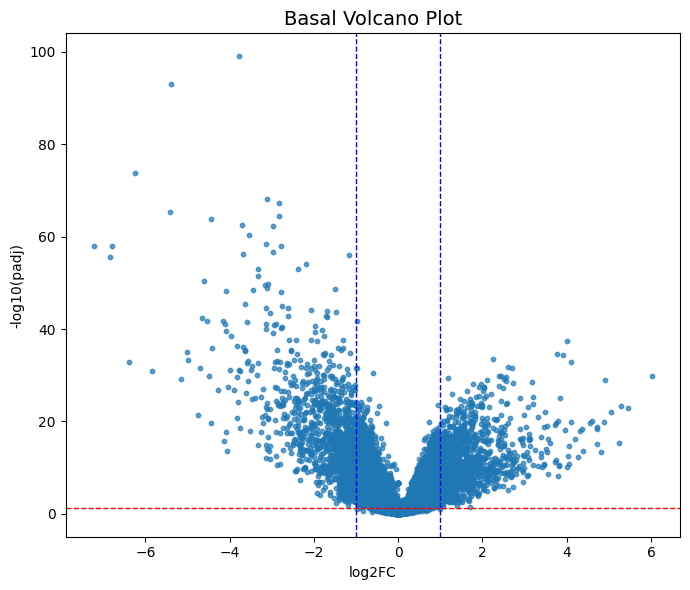

Plotting: Her2


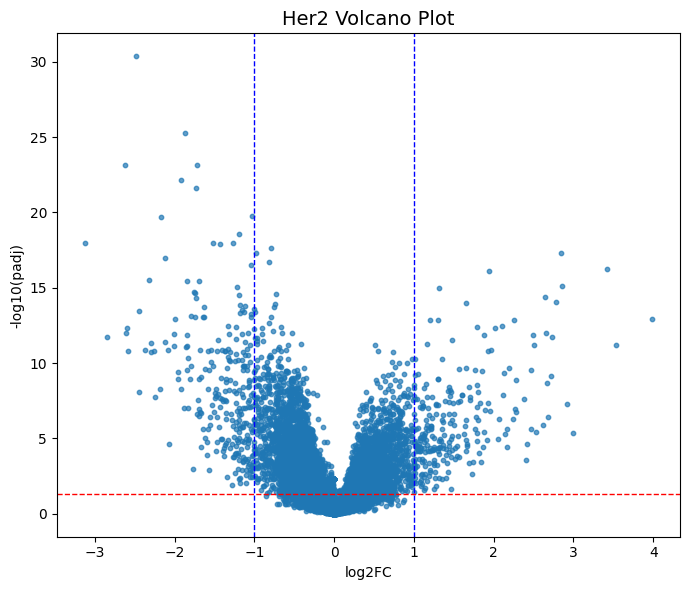

Plotting: Luminal_B


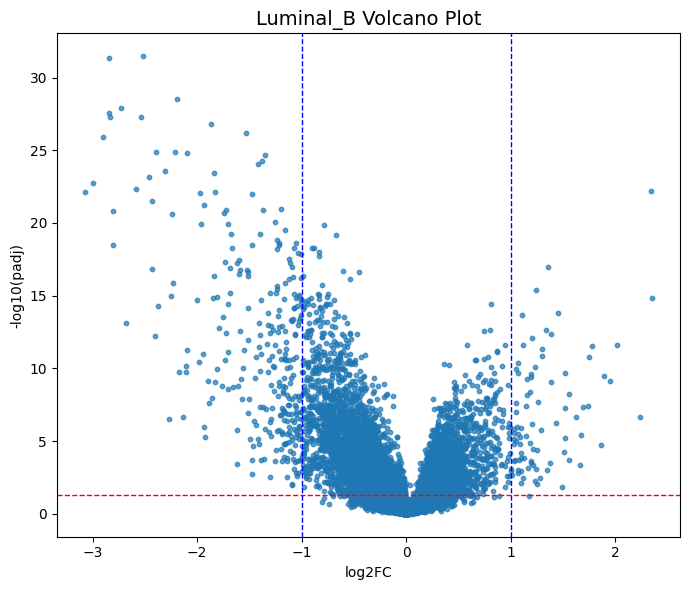

Plotting: Luminal_A


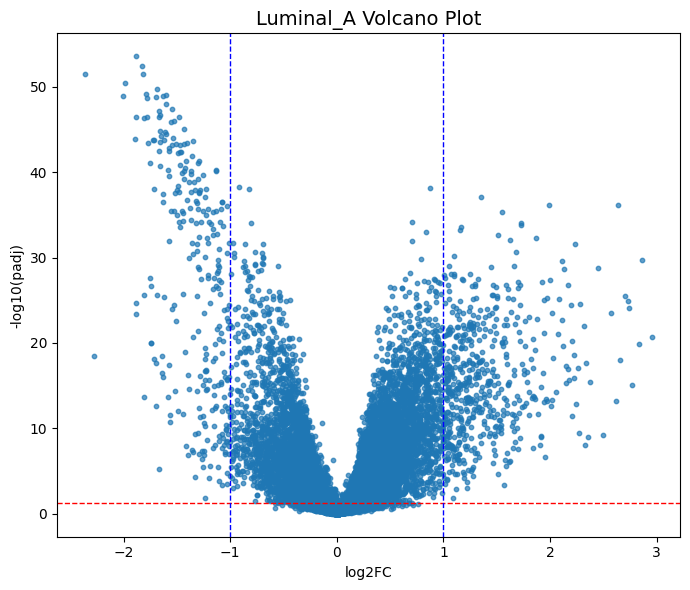

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# Volcano plotting function
# ----------------------------------------------------------
def plot_volcano(de_df, subtype):
    eps = 1e-300   # lower bound to avoid log(0)

    # Compute -log10(FDR)
    neglog = -np.log10(np.maximum(de_df["padj"].values, eps))

    plt.figure(figsize=(7, 6))

    # Scatter plot
    plt.scatter(
        de_df["log2FC"],
        neglog,
        s=10,
        alpha=0.7
    )

    # Reference lines
    # Horizontal for FDR = 0.05
    plt.axhline(-np.log10(0.05), color='red', linestyle='--', linewidth=1)

    # Vertical for log2FC = ±1
    plt.axvline(1, color='blue', linestyle='--', linewidth=1)
    plt.axvline(-1, color='blue', linestyle='--', linewidth=1)

    plt.title(f"{subtype} Volcano Plot", fontsize=14)
    plt.xlabel("log2FC")
    plt.ylabel("-log10(padj)")

    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------
# Generate volcano plot for each subtype
# ----------------------------------------------------------
for subtype in de_results.keys():
    print(f"Plotting: {subtype}")
    plot_volcano(de_results[subtype], subtype)

**Heatmap**

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1600x1000 with 0 Axes>

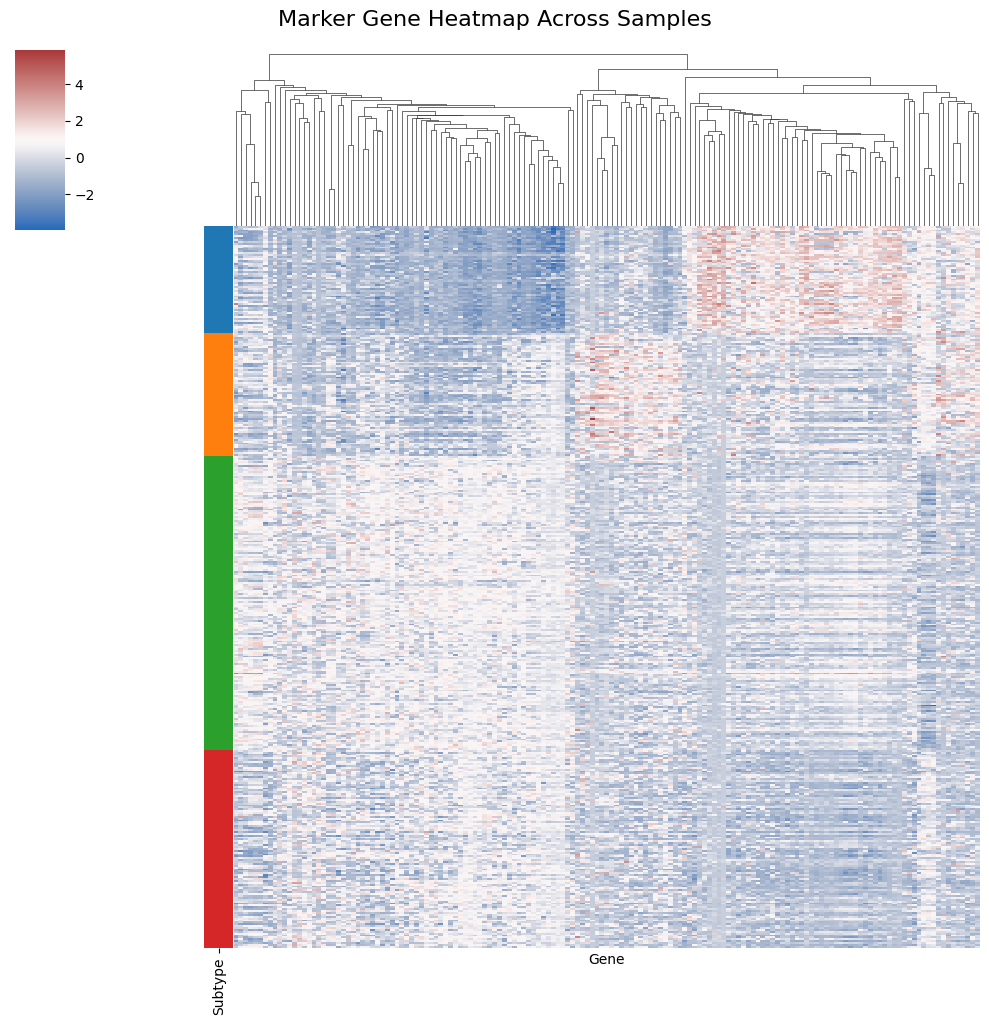

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# Collect top dysregulated marker genes across subtypes
# ---------------------------------------------------------
marker_genes = set()

for subtype in subtypes:
    de_df = de_results[subtype]

    # Significant genes only
    sig = de_df[de_df["padj"] < 0.05].copy()
    if sig.empty:
        continue

    # Rank by absolute log2 fold change
    sig["abs_log2FC"] = sig["log2FC"].abs()

    # Top 50 dysregulated genes
    top50 = sig.sort_values("abs_log2FC", ascending=False).head(50)

    # Add to global set
    marker_genes.update(top50["gene"].tolist())

# ---------------------------------------------------------
# Convert marker set to list and extract expression matrix
# ---------------------------------------------------------
marker_genes = list(marker_genes)
X_markers = X[marker_genes].copy()

# ---------------------------------------------------------
# Z-score standardize expression across samples
# ---------------------------------------------------------
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_markers),
    index=X_markers.index,
    columns=X_markers.columns
)

# ---------------------------------------------------------
# Sort samples by subtype label
# ---------------------------------------------------------
order = y.sort_values().index
X_scaled_ordered = X_scaled.loc[order]
y_ordered = y.loc[order]

# X_scaled_ordered and y_ordered now ready for heatmap plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# Create subtype → color mapping for annotation
# ---------------------------------------------------------
unique_subtypes = y_ordered.unique()

palette = sns.color_palette("tab10", len(unique_subtypes))
subtype_colors = {sub: palette[i] for i, sub in enumerate(unique_subtypes)}

# Color annotation vector
row_colors = y_ordered.map(subtype_colors)

# ---------------------------------------------------------
# Plot heatmap
# ---------------------------------------------------------
plt.figure(figsize=(16, 10))

sns.clustermap(
    X_scaled_ordered,
    row_cluster=False,       # keep sample order fixed
    col_cluster=True,        # cluster genes
    row_colors=row_colors,   # PAM50 annotation on rows
    cmap="vlag",
    linewidths=0,
    xticklabels=False,
    yticklabels=False
)

plt.suptitle("Marker Gene Heatmap Across Samples", fontsize=16, y=1.02)
plt.show()

**ML Model-All Genes**

In [29]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# ---------------------------------------------------------
# Machine-learning evaluation function
# ---------------------------------------------------------
def ml_train(X_input, y, label="ModelRun"):
    results = {}

    # ----------------------------
    # Train/test split
    # ----------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X_input,
        y,
        test_size=0.20,
        random_state=42,
        stratify=y
    )

    # ----------------------------
    # Standardization
    # ----------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ----------------------------
    # 1. Logistic Regression
    # ----------------------------
    logreg = LogisticRegression(
        max_iter=2000,
        multi_class="multinomial"
    )
    logreg.fit(X_train_scaled, y_train)
    y_pred = logreg.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    print(f"[{label}] LogisticRegression: acc={acc:.4f} f1={f1:.4f}")
    results["LogisticRegression"] = {
        "model": logreg,
        "acc": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, average="macro"),
        "y_test": y_test,
        "y_pred": y_pred,
        "X_test_scaled": X_test_scaled
    }

    # ----------------------------
    # 2. Random Forest
    # ----------------------------
    rf = RandomForestClassifier(n_estimators=300, random_state=42)
    rf.fit(X_train_scaled, y_train)
    y_pred = rf.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    print(f"[{label}] RandomForest: acc={acc:.4f} f1={f1:.4f}")
    results["RandomForest"] = {
        "model": rf,
        "acc": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, average="macro"),
        "y_test": y_test,
        "y_pred": y_pred,
        "X_test_scaled": X_test_scaled
    }

    # ----------------------------
    # 3. SVM (RBF kernel)
    # ----------------------------
    svm = SVC(kernel="rbf", probability=True, random_state=42)
    svm.fit(X_train_scaled, y_train)
    y_pred = svm.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    print(f"[{label}] SVM-RBF: acc={acc:.4f} f1={f1:.4f}")
    results["SVM-RBF"] = {
        "model": svm,
        "acc": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, average="macro"),
        "y_test": y_test,
        "y_pred": y_pred,
        "X_test_scaled": X_test_scaled
    }

    return results


# ---------------------------------------------------------
# Run ML evaluation on your full expression matrix
# ---------------------------------------------------------
results = ml_train(X, y, label="all")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[all] LogisticRegression: acc=0.8442 f1=0.8454
[all] RandomForest: acc=0.8701 f1=0.8519
[all] SVM-RBF: acc=0.8312 f1=0.8396


**ML Model-DE Selected Genes**

In [30]:
# ---------------------------------------------------------
# Subset expression matrix to DE-selected marker genes
# ---------------------------------------------------------
X_selected = X[marker_genes].copy()

print("Original feature count:", X.shape[1])
print("Selected feature count:", X_selected.shape[1])

# ---------------------------------------------------------
# Train ML models on reduced feature set
# ---------------------------------------------------------
results_selected = ml_train(X_selected, y, label="DE")

print("\nModel performance using DE-selected marker genes:")
for model, info in results_selected.items():
    acc = info["acc"]
    f1 = info["f1"]
    print(f"{model}: acc={acc:.4f}, f1={f1:.4f}")

Original feature count: 18802
Selected feature count: 153
[DE] LogisticRegression: acc=0.8831 f1=0.8862


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[DE] RandomForest: acc=0.8701 f1=0.8696
[DE] SVM-RBF: acc=0.8701 f1=0.8719

Model performance using DE-selected marker genes:
LogisticRegression: acc=0.8831, f1=0.8862
RandomForest: acc=0.8701, f1=0.8696
SVM-RBF: acc=0.8701, f1=0.8719


**ML Model-Random Genes**

In [31]:
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# Number of DE-selected marker genes
# ---------------------------------------------------------
k = len(marker_genes)
print("Number of DE-selected genes:", k)

# ---------------------------------------------------------
# Randomly sample k genes from the full expression matrix
# ---------------------------------------------------------
np.random.seed(42)   # for reproducibility
random_genes = np.random.choice(X.columns, size=k, replace=False)

# Build random-gene feature matrix
X_rand = X[random_genes].copy()

print("Random-gene feature count:", X_rand.shape[1])

# ---------------------------------------------------------
# Evaluate ML performance using the random gene set
# ---------------------------------------------------------
results_random = ml_train(X_rand, y, label="random")

print("\nModel performance using random genes:")
for model, info in results_random.items():
    acc = info["acc"]
    f1 = info["f1"]
    print(f"{model}: acc={acc:.4f}, f1={f1:.4f}")

Number of DE-selected genes: 153
Random-gene feature count: 153
[random] LogisticRegression: acc=0.7532 f1=0.7521


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[random] RandomForest: acc=0.7792 f1=0.7581
[random] SVM-RBF: acc=0.7922 f1=0.7948

Model performance using random genes:
LogisticRegression: acc=0.7532, f1=0.7521
RandomForest: acc=0.7792, f1=0.7581
SVM-RBF: acc=0.7922, f1=0.7948


**Comparison Table**

In [32]:
import pandas as pd

rows = []

for model in results.keys():
    all_acc = results[model]["acc"]
    all_f1  = results[model]["f1"]

    de_acc  = results_selected[model]["acc"]
    de_f1   = results_selected[model]["f1"]

    rand_acc = results_random[model]["acc"]
    rand_f1  = results_random[model]["f1"]

    row = {
        "model": model,
        "all_acc": all_acc,
        "de_acc": de_acc,
        "rand_acc": rand_acc,
        "all_f1": all_f1,
        "de_f1": de_f1,
        "rand_f1": rand_f1
    }

    rows.append(row)

# Convert to DataFrame
compare = pd.DataFrame(rows)
compare

,model,all_acc,de_acc,rand_acc,all_f1,de_f1,rand_f1
0,LogisticRegression,0.844156,0.883117,0.753247,0.845400,0.88618,0.752067
1,RandomForest,0.870130,0.870130,0.779221,0.851925,0.86958,0.758111
2,SVM-RBF,0.831169,0.870130,0.792208,0.839608,0.87189,0.794752


**Confusion Matrices- DE Selected**


=== Confusion Matrix: LogisticRegression ===
Labels order: ['Basal', 'Her2', 'Luminal_A', 'Luminal_B']
[[12  0  0  0]
 [ 0 11  1  1]
 [ 0  0 30  1]
 [ 0  2  4 15]]


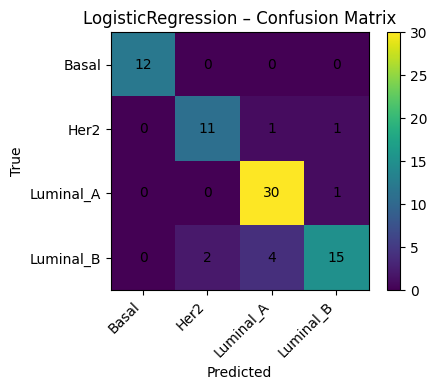


=== Confusion Matrix: RandomForest ===
Labels order: ['Basal', 'Her2', 'Luminal_A', 'Luminal_B']
[[12  0  0  0]
 [ 0 10  1  2]
 [ 0  0 30  1]
 [ 0  2  4 15]]


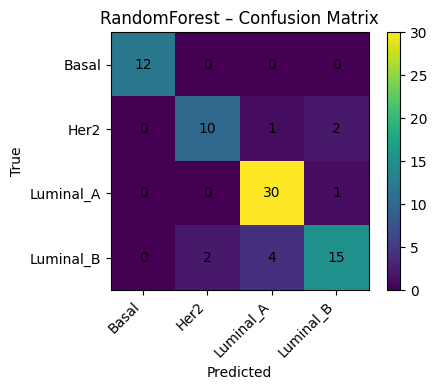


=== Confusion Matrix: SVM-RBF ===
Labels order: ['Basal', 'Her2', 'Luminal_A', 'Luminal_B']
[[12  0  0  0]
 [ 0 11  1  1]
 [ 0  0 31  0]
 [ 0  2  6 13]]


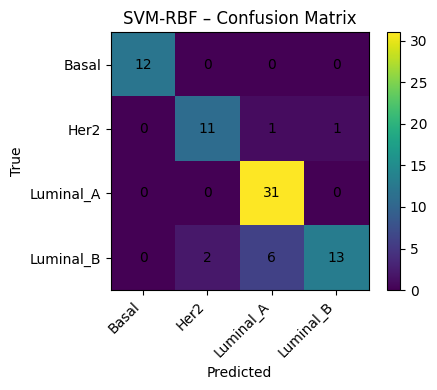

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()

    # Axis labels
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(np.arange(len(class_names)), class_names)

    # Cell annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center", color="black")

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------
# Generate confusion matrices for each trained model
# ---------------------------------------------------
class_names = sorted(y.unique())

for name, info in results_selected.items():
    print(f"\n=== Confusion Matrix: {name} ===")

    y_test = info["y_test"]      # from ml_train return structure
    y_pred = info["y_pred"]      # predicted labels stored earlier

    cm = confusion_matrix(y_test, y_pred, labels=class_names)

    print("Labels order:", class_names)
    print(cm)

    # Plot matrix
    plot_confusion_matrix(cm, class_names, f"{name} – Confusion Matrix")


**Strongest DE signals**

In [22]:
# Inspect strongest DE signals per PAM50 subtype

for subtype in subtypes:
    print(f"\nSubtype: {subtype}")

    # Retrieve DE results for the subtype
    de_df = de_results[subtype]

    # Sort by adjusted p-value (ascending = most significant first)
    top3 = de_df.sort_values("padj").head(3)

    # Display selected columns only
    display(top3[["gene", "log2FC", "pval", "padj"]])



Subtype: Basal


,gene,log2FC,pval,padj
0,FSIP1,-3.783628,4.546742e-104,8.548784e-100
1,ANKRD30A,-5.380552,7.640064e-98,7.182424e-94
2,C1orf64,-6.240288,3.175599e-78,1.990254e-74



Subtype: Her2


,gene,log2FC,pval,padj
0,CST9,-2.491195,2.315307e-35,4.353240e-31
1,FAM196A,-1.866626,6.063326e-30,5.700132e-26
2,TMEM26,-1.721219,1.063599e-27,6.665930e-24



Subtype: Luminal_B


,gene,log2FC,pval,padj
0,KLK8,-2.515889,1.814609e-36,3.411829e-32
1,SFRP1,-2.838940,4.513598e-36,4.243233e-32
2,PPP1R14C,-2.190545,5.045795e-33,3.162368e-29



Subtype: Luminal_A


,gene,log2FC,pval,padj
0,MCM10,-1.881067,1.441461e-58,2.710235e-54
1,AURKB,-1.832489,4.254045e-57,3.999228e-53
2,ORC6,-1.820092,6.434429e-56,3.558474e-52


In [14]:
!pip install umap-learn


**2D UMAP Visialization**

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


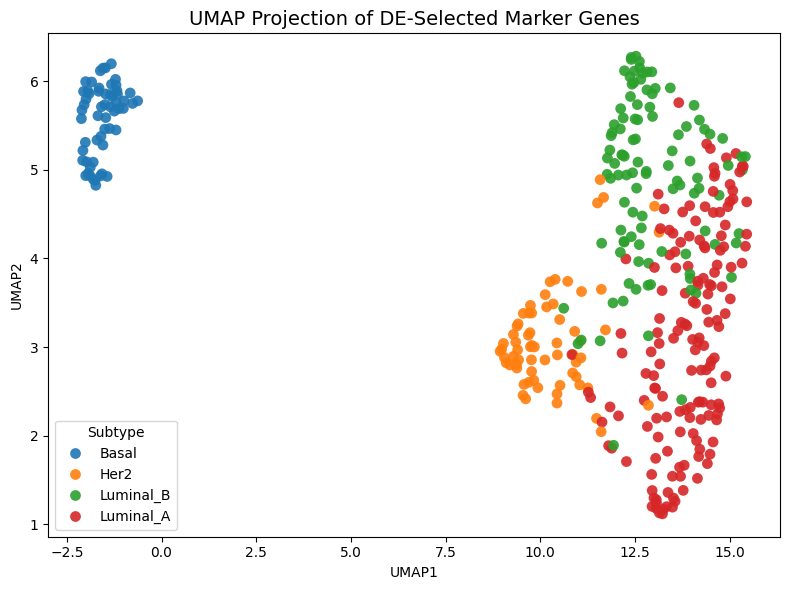

In [15]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ---------------------------------------------------------
# 1. Subset to DE-selected genes
# ---------------------------------------------------------
X_selected = X[marker_genes].copy()

# ---------------------------------------------------------
# 2. Standardize DE gene expression
# ---------------------------------------------------------
scaler = StandardScaler()
X_sel_scaled = scaler.fit_transform(X_selected)

# ---------------------------------------------------------
# 3. UMAP embedding
# ---------------------------------------------------------
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42
)

embedding_sel = umap_model.fit_transform(X_sel_scaled)

# ---------------------------------------------------------
# 4. Prepare data for plotting
# ---------------------------------------------------------
plot_df = pd.DataFrame({
    "UMAP1": embedding_sel[:, 0],
    "UMAP2": embedding_sel[:, 1],
    "Subtype": y.values
})

# ---------------------------------------------------------
# 5. Plot UMAP with subtype colors
# ---------------------------------------------------------
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=plot_df,
    x="UMAP1",
    y="UMAP2",
    hue="Subtype",
    palette="tab10",
    s=60,
    alpha=0.9,
    edgecolor="none"
)

plt.title("UMAP Projection of DE-Selected Marker Genes", fontsize=14)
plt.tight_layout()
plt.show()

**Cross Validation and HyperParameter Tuning**

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

def cross_val_eval(X_input, y, label, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    models = {
        "LogReg": LogisticRegression(max_iter=2000, multi_class="multinomial"),
        "RF": RandomForestClassifier(n_estimators=300, random_state=42),
        "SVM": SVC(kernel="rbf", C=1.0, gamma="scale")
    }

    results = {name: {"acc": [], "f1": []} for name in models.keys()}

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_input, y), start=1):
        X_train, X_test = X_input.iloc[train_idx], X_input.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train)
        X_test_sc  = scaler.transform(X_test)

        print(f"\n[{label}] Fold {fold}/{n_splits}")
        for name, model in models.items():
            model.fit(X_train_sc, y_train)
            y_pred = model.predict(X_test_sc)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="macro")
            results[name]["acc"].append(acc)
            results[name]["f1"].append(f1)
            print(f"  {name}: acc={acc:.3f}, f1={f1:.3f}")

    # summarize
    summary = []
    for name in models.keys():
        summary.append({
            "model": name,
            "acc_mean": np.mean(results[name]["acc"]),
            "acc_std": np.std(results[name]["acc"]),
            "f1_mean": np.mean(results[name]["f1"]),
            "f1_std": np.std(results[name]["f1"])
        })
    return pd.DataFrame(summary)

print("=== 5-fold CV: ALL GENES ===")
cv_all = cross_val_eval(X, y, label="All genes")

print("\n=== 5-fold CV: DE GENES ===")
X_de = X[marker_genes]
cv_de = cross_val_eval(X_de, y, label="DE genes")

print("\nCV summary - All genes:")
display(cv_all)

print("\nCV summary - DE genes:")
display(cv_de)


=== 5-fold CV: ALL GENES ===

[All genes] Fold 1/5


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  LogReg: acc=0.857, f1=0.853
  RF: acc=0.844, f1=0.820
  SVM: acc=0.766, f1=0.754

[All genes] Fold 2/5


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  LogReg: acc=0.883, f1=0.891
  RF: acc=0.870, f1=0.860
  SVM: acc=0.831, f1=0.824

[All genes] Fold 3/5


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  LogReg: acc=0.883, f1=0.891
  RF: acc=0.935, f1=0.940
  SVM: acc=0.844, f1=0.841

[All genes] Fold 4/5


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  LogReg: acc=0.868, f1=0.884
  RF: acc=0.868, f1=0.872
  SVM: acc=0.855, f1=0.850

[All genes] Fold 5/5


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  LogReg: acc=0.882, f1=0.873
  RF: acc=0.908, f1=0.920
  SVM: acc=0.842, f1=0.841

=== 5-fold CV: DE GENES ===

[DE genes] Fold 1/5
  LogReg: acc=0.818, f1=0.832


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  RF: acc=0.831, f1=0.842
  SVM: acc=0.805, f1=0.817

[DE genes] Fold 2/5
  LogReg: acc=0.935, f1=0.943


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  RF: acc=0.883, f1=0.904
  SVM: acc=0.922, f1=0.932

[DE genes] Fold 3/5
  LogReg: acc=0.961, f1=0.965


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  RF: acc=0.961, f1=0.970
  SVM: acc=0.948, f1=0.960

[DE genes] Fold 4/5
  LogReg: acc=0.829, f1=0.846


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  RF: acc=0.908, f1=0.907
  SVM: acc=0.908, f1=0.907

[DE genes] Fold 5/5
  LogReg: acc=0.908, f1=0.902


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  RF: acc=0.921, f1=0.921
  SVM: acc=0.882, f1=0.886

CV summary - All genes:


,model,acc_mean,acc_std,f1_mean,f1_std
0,LogReg,0.874675,0.010360,0.878487,0.014306
1,RF,0.885133,0.032233,0.882562,0.042897
2,SVM,0.827785,0.031712,0.822158,0.035113



CV summary - DE genes:


,model,acc_mean,acc_std,f1_mean,f1_std
0,LogReg,0.890226,0.057066,0.897700,0.051838
1,RF,0.900854,0.043013,0.908794,0.040892
2,SVM,0.892960,0.048864,0.900426,0.048475


In [17]:
from sklearn.model_selection import GridSearchCV, train_test_split

# Use DE-selected genes
X_de = X[marker_genes]

X_train_de, X_test_de, y_train_de, y_test_de = train_test_split(
    X_de, y, test_size=0.2, stratify=y, random_state=42
)

scaler_de = StandardScaler()
X_train_de_sc = scaler_de.fit_transform(X_train_de)
X_test_de_sc  = scaler_de.transform(X_test_de)

# ---- RandomForest tuning ----
rf_base = RandomForestClassifier(random_state=42)
rf_param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [None, 10, 30],
    "min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(
    rf_base,
    rf_param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)
rf_grid.fit(X_train_de_sc, y_train_de)
print("Best RF params:", rf_grid.best_params_)

# ---- SVM tuning ----
svm_base = SVC(kernel="rbf", probability=True)
svm_param_grid = {
    "C": [0.1, 1.0, 10.0],
    "gamma": ["scale", 0.01, 0.001]
}

svm_grid = GridSearchCV(
    svm_base,
    svm_param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)
svm_grid.fit(X_train_de_sc, y_train_de)
print("Best SVM params:", svm_grid.best_params_)

# ---- Evaluate tuned models on held-out test set ----
from sklearn.metrics import classification_report

best_rf = rf_grid.best_estimator_
best_svm = svm_grid.best_estimator_

for name, model in [("RF_tuned", best_rf), ("SVM_tuned", best_svm)]:
    print(f"\n{name} performance on held-out test set:")
    y_pred = model.predict(X_test_de_sc)
    acc = accuracy_score(y_test_de, y_pred)
    f1 = f1_score(y_test_de, y_pred, average="macro")
    print(f"  Accuracy = {acc:.3f}, Macro F1 = {f1:.3f}")
    print(classification_report(y_test_de, y_pred))


Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best SVM params: {'C': 10.0, 'gamma': 'scale'}

RF_tuned performance on held-out test set:
  Accuracy = 0.870, Macro F1 = 0.870
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00        12
        Her2       0.83      0.77      0.80        13
   Luminal_A       0.86      0.97      0.91        31
   Luminal_B       0.83      0.71      0.77        21

    accuracy                           0.87        77
   macro avg       0.88      0.86      0.87        77
weighted avg       0.87      0.87      0.87        77


SVM_tuned performance on held-out test set:
  Accuracy = 0.857, Macro F1 = 0.865
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00        12
        Her2       0.85      0.85      0.85        13
   Luminal_A       0.83      0.94      0.88        31
   Luminal_B       0.82      0.67      0.74        21

  